# Описание

Мы - онлайн магазин спортивных товаров: одежды, обуви, аксессуаров и спорт-питания. На главной странице магазина мы показываем пользователям баннеры с целью стимулирования своих продаж. Сейчас там случайно показывается один из 5 баннеров. Каждый баннер рекламирует конкретный продукт или всю компанию. Наши маркетологи считают, что опыт взаимодействия с баннерами может различаться по сегментам, а их эффективность - зависеть от особенностей пользовательского поведения.

У менеджера компании появилось предложение от партнеров: продать это место для баннера и рекламировать там другой сервис (оплата предполагается по CPC-модели, т.е. стоимость за клик).

Помогите менеджеру принять решение - нужно ли продавать это место для рекламы другого сервиса.


Описание данных:

- `title` - тип события (показ, клик или покупка)
- `user` - уникальный идентификатор клиента
- `product` - продукт баннера/покупки
- `page_id` - уникальный номер страницы для связки событий (NA для покупок)
- `order_id` - уникальный номер покупки (NA для кликов и показов баннера)
- `time` - время совершения действия
- `site_version` - версия сайта (мобильная или десктопная)


### Импорт библиотек

In [267]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

pd.set_option('display.max_columns', None)

from IPython.display import HTML, display
display(HTML("<style>.container { width:70% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

### EDA

In [268]:
df = pd.read_csv('ha_data.csv', sep=';')

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471226 entries, 0 to 8471225
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   order_id      float64
 1   page_id       float64
 2   product       object 
 3   site_version  object 
 4   time          object 
 5   title         object 
 6   user          object 
dtypes: float64(2), object(5)
memory usage: 452.4+ MB


In [270]:
df.head()

,order_id,page_id,product,site_version,time,title,user
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1


Нужно оптимизировать такой тяжелый датасет.

`order_id` удалим. Данный признак нам не понадобятся, т.к. он дублируется значением **order** в столбце `title`

In [271]:
df = df.drop(['order_id'], axis=1)

Тип данных object (кроме столбца user - в категорийном формате он больше весит) приведем к category, float64 - к float32

In [272]:
obj_col = df.select_dtypes(include=['object']).columns[:-1]
float_col = df.select_dtypes(include=['float64']).columns

In [273]:
obj_col

Index(['product', 'site_version', 'time', 'title'], dtype='object')

In [274]:
df[obj_col] = df[obj_col].astype('category')
df[float_col] = df[float_col].astype('float32')

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471226 entries, 0 to 8471225
Data columns (total 6 columns):
 #   Column        Dtype   
---  ------        -----   
 0   page_id       float32 
 1   product       category
 2   site_version  category
 3   time          category
 4   title         category
 5   user          object  
dtypes: category(4), float32(1), object(1)
memory usage: 326.7+ MB


Было 450 Мб, стало 320. Продолжаем EDA.

In [276]:
def print_dataset_info(df):

    print("\nКоличество дубликатов:")
    display(df.duplicated().sum())
    print("\nКоличество пропусков:")
    display(df.isna().sum())

In [277]:
print_dataset_info(df)


Количество дубликатов:


0


Количество пропусков:


page_id         248722
product              0
site_version         0
time                 0
title                0
user                 0
dtype: int64

Посмотрим на соотношения значений в столбцах

In [278]:
def display_unique_values(df, column_name):
    ratios = df[column_name].value_counts(normalize=True) * 100
    
    print("Соотношения значений:")
    print(round(ratios, 3))

In [279]:
display_unique_values(df, 'product')

Соотношения значений:
clothes             21.088
company             20.364
sneakers            20.107
sports_nutrition    19.296
accessories         19.144
Name: product, dtype: float64


In [280]:
display_unique_values(df, 'site_version')

Соотношения значений:
mobile     71.871
desktop    28.129
Name: site_version, dtype: float64


In [281]:
display_unique_values(df, 'title')

Соотношения значений:
banner_show     87.276
banner_click     9.788
order            2.936
Name: title, dtype: float64


`time` удалим. Этот признак никак не поможет нам определить конверсии

In [282]:
df = df.drop(['time'], axis=1)

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471226 entries, 0 to 8471225
Data columns (total 5 columns):
 #   Column        Dtype   
---  ------        -----   
 0   page_id       float32 
 1   product       category
 2   site_version  category
 3   title         category
 4   user          object  
dtypes: category(3), float32(1), object(1)
memory usage: 121.2+ MB


- Продукты рекламируются практически в одинаковых объемах
- Пользователи чаще пользуются мобильной версией (приложением), чем заходят с сайта
- Сократили объем датасета с 450 Мб до 120 Мб

### Агрегация данных

Посчитаем показы баннера, количество кликов на баннер, количество покупок в каждой из категорий рекламы и в каждой версии приложения

In [284]:
impressions = df[df['title'] == 'banner_show'].groupby(['product', 'site_version'])['user'].count() # Показы
clicks = df[df['title'] == 'banner_click'].groupby(['product', 'site_version'])['user'].count() # Клики
purchases = df[df['title'] == 'order'].groupby(['product', 'site_version'])['user'].count() # Покупки

In [285]:
impressions

product           site_version
accessories       desktop          410003
                  mobile          1030951
clothes           desktop          418070
                  mobile          1035058
company           desktop          477374
                  mobile          1102864
sneakers          desktop          411598
                  mobile          1041431
sports_nutrition  desktop          417595
                  mobile          1048375
Name: user, dtype: int64

In [286]:
clicks

product           site_version
accessories       desktop          18531
                  mobile          117723
clothes           desktop          32781
                  mobile          187814
company           desktop          28464
                  mobile          116357
sneakers          desktop          21419
                  mobile          161178
sports_nutrition  desktop          13870
                  mobile          131048
Name: user, dtype: int64

In [287]:
purchases

product           site_version
accessories       desktop         22121
                  mobile          22430
clothes           desktop         66977
                  mobile          45738
company           desktop             0
                  mobile              0
sneakers          desktop         32565
                  mobile          35154
sports_nutrition  desktop         11518
                  mobile          12219
Name: user, dtype: int64

### CTR

Метрика **CTR** (Click-Through Rate) позволяет рассчитать коэффициент кликабельности для каждого баннера. Чтобы рассчитать данный коэффициент, нужно клики разделить на показы.

In [288]:
ctr = ((clicks / impressions) * 100).reset_index()
ctr = ctr.rename(columns={"user": "ratio"})

In [289]:
ctr_total_platf = ctr.groupby('product')['ratio'].sum().reset_index()

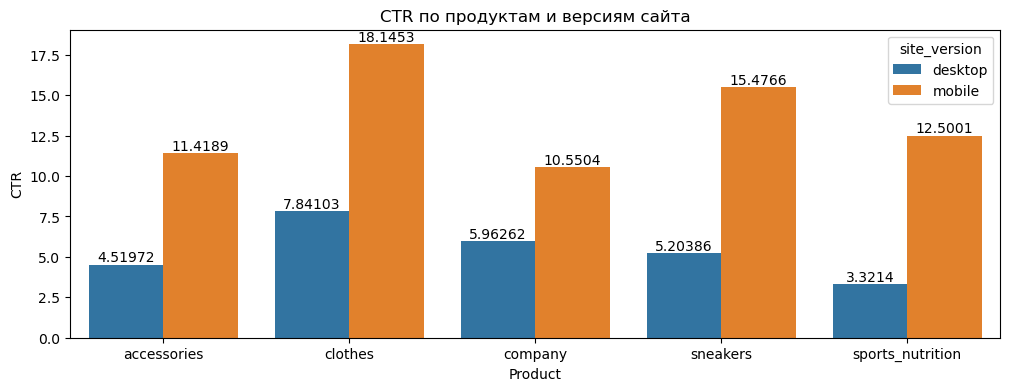

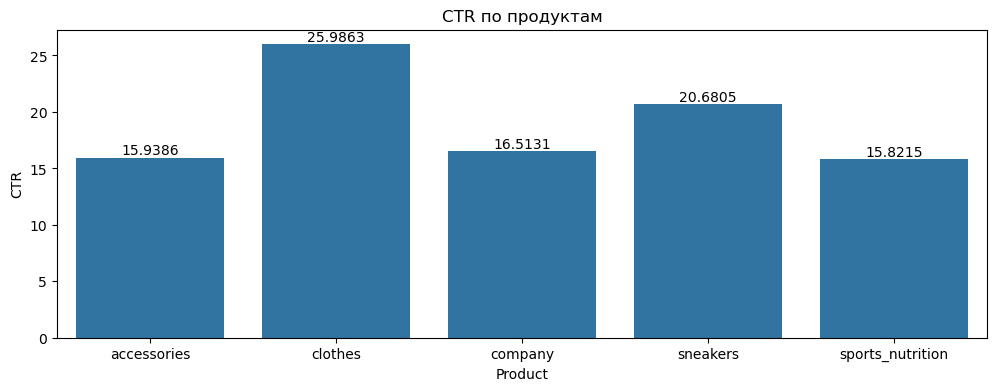

In [290]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(data=ctr, x='product', y='ratio', hue='site_version')

plt.title('CTR по продуктам и версиям сайта')
plt.xlabel('Product')
plt.ylabel('CTR')

ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)

plt.show()

plt.figure(figsize=(12, 4))
ax = sns.barplot(data=ctr_total_platf, x='product', y='ratio')

plt.title('CTR по продуктам')
plt.xlabel('Product')
plt.ylabel('CTR')

ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

- Самый высокий CTR у "clothes" - 25%. Почти каждый четвертый кликает по баннеру с рекламой одежды.
- Самые некликабельные баннеры - "accessories", "company", "sports_nutrition" - примерно 15%.
- CTR мобильной версии заметно выше, чем десктопной.
- На мобилках чаще кликают на баннер с одеждой.
- На мобилках реже кликают на баннер со спортивным питанием.
___

### CR

#### Первый расчет метрики

Метрика **CR** (Conversion Rate) позволяет оценить конверсию с кликов на покупки. Чтобы рассчитать данную конверсию, нужно покупки разделить на клики.

In [291]:
cr = ((purchases / clicks) * 100).reset_index()
cr = cr.rename(columns={"user": "ratio"})
cr_total_platf = cr.groupby('product')['ratio'].sum().reset_index()

In [292]:
cr

,product,site_version,ratio
0,accessories,desktop,119.372943
1,accessories,mobile,19.053201
2,clothes,desktop,204.316525
3,clothes,mobile,24.352817
4,company,desktop,0.000000
5,company,mobile,0.000000
6,sneakers,desktop,152.037910
7,sneakers,mobile,21.810669
8,sports_nutrition,desktop,83.042538
9,sports_nutrition,mobile,9.324064


На десктопе получили аномальные значения - они больше 100%. Есть версия, что некоторые покупки были сделаны без предварительного клика на баннер. Стоит ее проверить
___

#### Поиск "небаннерных" покупок

Удаляем 'site_version', т.к. платформа не имеет значения в данном случае

In [293]:
df_copy = df.drop('site_version', axis=1).reset_index()

Создадим отдельные датафреймы со статусами order и banner_click

In [294]:
order_filtered = df_copy[df_copy['title'] == 'order']

In [295]:
banner_click_filtered = df_copy[df_copy['title'] == 'banner_click']

Смерджим к данным с покупками данные с кликами в разрезе пользователя и продукта - это поможет понять, был ли клик на баннер перед покупкой определенного товара покупателем или нет.

In [296]:
merged = order_filtered.merge(banner_click_filtered, on=['user', 'product'], suffixes=('_order', '_click'), how='left')

In [297]:
merged.head(5)

,index_order,page_id_order,product,title_order,user,index_click,page_id_click,title_click
0,66,NaN,sports_nutrition,order,user_21,NaN,NaN,NaN
1,112,NaN,sneakers,order,user_35,NaN,NaN,NaN
2,113,NaN,clothes,order,user_35,110.0,1687.0,banner_click
3,171,NaN,sports_nutrition,order,user_53,NaN,NaN,NaN
4,185,NaN,accessories,order,user_55,NaN,NaN,NaN


Наличие пустых значений в столбцах `_click` говорит о том, что товар был куплен пользователем не через клик по баннеру.

**Теория оказалась верна**
___
Оставим в таблице **merged** только "небаннерные" покупки

In [298]:
merged_clear = merged.query('title_click.isna()')

Составим список индексов "небаннерных" покупок

In [299]:
index_list = merged_clear['index_order'].to_list()

In [300]:
len(index_list)

220084

Удалим их из общего датасета

In [301]:
df.shape

(8471226, 5)

In [302]:
df = df.drop(index=index_list)

In [303]:
df.shape

(8251142, 5)

#### Финальный расчет метрики

In [304]:
purchases = df[df['title'] == 'order'].groupby(['product', 'site_version'])['user'].count() # Покупки

In [305]:
cr = ((purchases / clicks) * 100).reset_index()
cr = cr.rename(columns={"user": "ratio"})
cr_total_platf = cr.groupby('product')['ratio'].sum().reset_index()

In [306]:
cr

,product,site_version,ratio
0,accessories,desktop,7.797744
1,accessories,mobile,2.508431
2,clothes,desktop,17.796895
3,clothes,mobile,4.341529
4,company,desktop,0.000000
5,company,mobile,0.000000
6,sneakers,desktop,10.429992
7,sneakers,mobile,3.538324
8,sports_nutrition,desktop,4.361932
9,sports_nutrition,mobile,1.304865


In [307]:
cr_total_platf

,product,ratio
0,accessories,10.306175
1,clothes,22.138424
2,company,0.000000
3,sneakers,13.968316
4,sports_nutrition,5.666798


Получили намного более адекватные значения

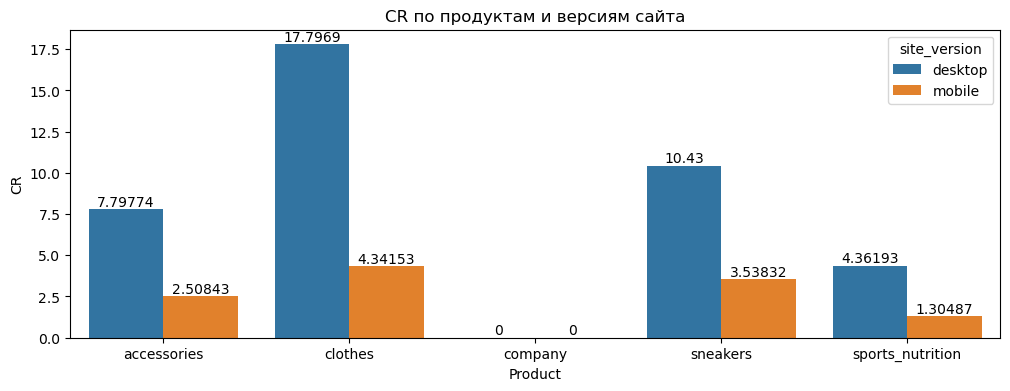

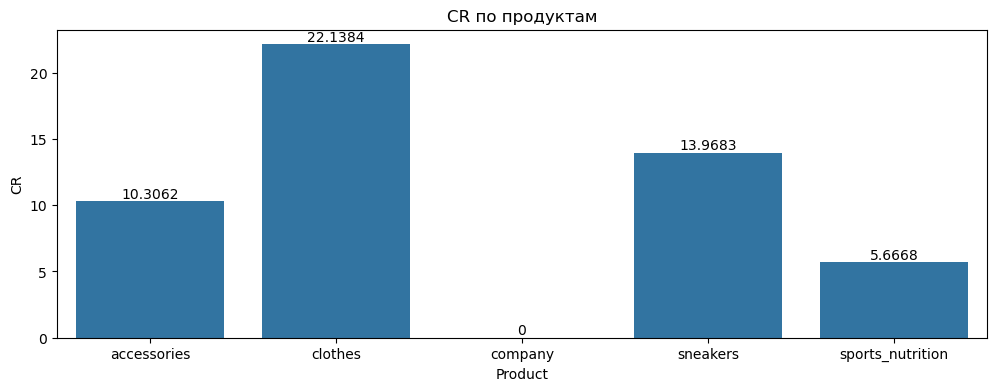

In [308]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(data=cr, x='product', y='ratio', hue='site_version')

plt.title('CR по продуктам и версиям сайта')
plt.xlabel('Product')
plt.ylabel('CR')

ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)

plt.show()

plt.figure(figsize=(12, 4))
ax = sns.barplot(data=cr_total_platf, x='product', y='ratio')

plt.title('CR по продуктам')
plt.xlabel('Product')
plt.ylabel('CR')

ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

- Самый высокий CR у "clothes" - 22%.
- У "sports_nutrition" самая маленькая конверсия в покупки - чуть больше 5%.
- В то время, как CTR мобильной версии заметно выше, чем десктопной, то с CR картина противоположная: конверсия в покупки выше с десктопа.
- Конверсия в покупку у моблильной версии крайне низок
___

### Итог

По условию задачи у менеджера компании появилось предложение от партнеров: продать это место для баннера и рекламировать там другой сервис (оплата предполагается по CPC-модели, т.е. стоимость за клик). Посмотрим на полученные CTR и CR

In [309]:
def plot(data, name):
    plt.figure(figsize=(12, 4))
    ax = sns.barplot(data=data, x='product', y='ratio', hue='site_version')

    plt.title(f'{name} по продуктам и версиям сайта')
    plt.xlabel('Product')
    plt.ylabel(f'{name}')

    ax.bar_label(ax.containers[0], fontsize=10)
    ax.bar_label(ax.containers[1], fontsize=10)

    plt.show()

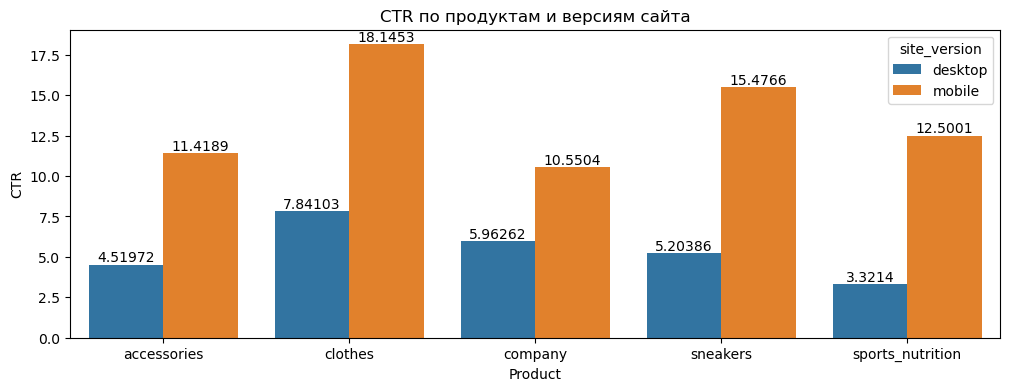

In [310]:
plot(ctr, 'CTR')

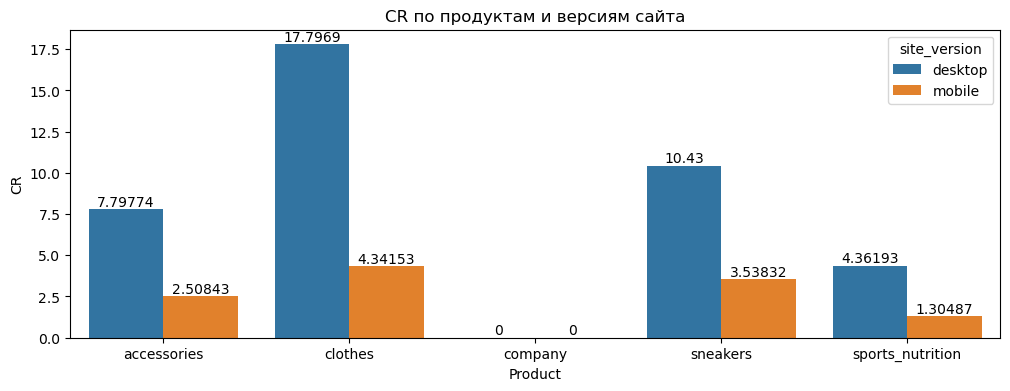

In [311]:
plot(cr, 'CR')

- Мобильная версия сайта демонстрирует высокий CTR, но низкий CR. Это означает, что пользователи кликают на баннеры, но менее склонны делать покупки.
- Десктопная версия имеет более низкий CTR, но высокий CR по основным категориям товаров, особенно для clothes и sneakers. Это говорит о том, что баннеры на десктопе более склонны стимулировать покупки, несмотря на меньший объем кликов. Уверен, сказывается более удобный опыт пользования именно десктопом, а не мобильным приложением.
- Недостаточно информации о баннерах с компанией. Возможно, вообще стоит отказаться от них, т.к. данная реклама не генерирует прибыли (по крайней мере, в данных нет об этом информации).
___
Рекомендации менеджеру:
- Т.к. мобильная версия сайта демонстрирует высокий CTR, есть смысл продать место для компании-партнера. Для моделей оплаты за клик (CPC) высокая кликабельность - это ключевой показатель, так как основной доход будет генерироваться через количество кликов.
- В продаже на десктопной версии смысла не вижу: CTR и так небольшой, появление баннеров другой компании могут повлиять на прибыль, ведь именно с десктопной версии больше всего кликов конвертируется в покупки.